# Outros modelos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_CATEGORIZADOS
from src.modelos import organiza_resultados, treinar_e_validar_modelo_regressao

sns.set_theme(palette="bright")

RANDOM_STATE = 42

In [2]:
df = pd.read_parquet(DADOS_CATEGORIZADOS)

df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.099998,101.0,157,93.199997,38.0,4.8598,87,151,4-5
1,48,1,21.600000,87.0,183,103.199997,70.0,3.8918,69,75,2-3
2,72,2,30.500000,93.0,156,93.599998,41.0,4.6728,85,141,4-5
3,24,1,25.299999,84.0,198,131.399994,40.0,4.8903,89,206,4-5
4,50,1,23.000000,101.0,192,125.400002,52.0,4.2905,80,135,4-5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    int8    
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float32(5), int16(2), int8(3)
memory usage: 12.3 KB


In [4]:
X = df.drop(columns="target")
y = df["target"]

In [5]:
colunas_power_transform = ["imc", "ldl", "hdl", "colesterol_total"]

coluna_target = ["target"]

coluna_ordinal_encoder = ["colesterol_hdl_cat"]

coluna_one_hot_encoder = ["sexo"]

colunas_standard_scaler = [
    coluna
    for coluna in df.columns
    if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

colunas_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [6]:
categorias_ordinal_encoder = [
    ["2-3", "4-5", "6+"],
]

In [7]:
X.columns.difference(coluna_ordinal_encoder + coluna_one_hot_encoder)

Index(['colesterol_total', 'glicose', 'hdl', 'idade', 'imc', 'ldl',
       'pressao_media', 'triglicerides'],
      dtype='object')

In [8]:
preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="if_binary"), coluna_one_hot_encoder),
    ],
    remainder="passthrough",
)

preprocessamento_simples = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="if_binary"), coluna_one_hot_encoder),
        ("standard_scaler", StandardScaler(), X.columns.difference(coluna_ordinal_encoder + coluna_one_hot_encoder)),
    ],
    remainder="passthrough",
)

preprocessamento_completo = ColumnTransformer(
    [
        ("power_transform", PowerTransformer(method="box-cox"), colunas_power_transform),
        ("standard_scaler", StandardScaler(), colunas_standard_scaler),
        ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="if_binary"), coluna_one_hot_encoder),
    ]
)

In [9]:
target_transformer = QuantileTransformer(n_quantiles=20, output_distribution="normal")

In [10]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression_pre_cat": {
        "preprocessor": preprocessamento_categoricas,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_pre_simples": {
        "preprocessor": preprocessamento_simples,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_pre_completo": {
        "preprocessor": preprocessamento_completo,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_pre_completo_target": {
        "preprocessor": preprocessamento_completo,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    
    "Lasso_pre_cat": {
        "preprocessor": preprocessamento_categoricas,
        "regressor": Lasso(),
        "target_transformer": None,
    },
    "Lasso_pre_simples": {
        "preprocessor": preprocessamento_simples,
        "regressor": Lasso(),
        "target_transformer": None,
    },
    "Lasso_pre_completo": {
        "preprocessor": preprocessamento_completo,
        "regressor": Lasso(),
        "target_transformer": None,
    },
    "Lasso_pre_completo_target": {
        "preprocessor": preprocessamento_completo,
        "regressor": Lasso(),
        "target_transformer": target_transformer,
    },
    "Lasso_pre_completo_target_hiper": {
        "preprocessor": preprocessamento_completo,
        "regressor": Lasso(alpha=0.1),
        "target_transformer": target_transformer,
    },
    
    "Ridge_pre_cat": {
        "preprocessor": preprocessamento_categoricas,
        "regressor": Ridge(),
        "target_transformer": None,
    },
    "Ridge_pre_simples": {
        "preprocessor": preprocessamento_simples,
        "regressor": Ridge(),
        "target_transformer": None,
    },
    "Ridge_pre_completo": {
        "preprocessor": preprocessamento_completo,
        "regressor": Ridge(),
        "target_transformer": None,
    },
    "Ridge_pre_completo_target": {
        "preprocessor": preprocessamento_completo,
        "regressor": Ridge(),
        "target_transformer": target_transformer,
    },
    "Ridge_pre_completo_target_hiper": {
        "preprocessor": preprocessamento_completo,
        "regressor": Ridge(alpha=0.1),
        "target_transformer": target_transformer,
    },
    
    "ElasticNet_pre_cat": {
        "preprocessor": preprocessamento_categoricas,
        "regressor": ElasticNet(),
        "target_transformer": None,
    },
    "ElasticNet_pre_simples": {
        "preprocessor": preprocessamento_simples,
        "regressor": ElasticNet(),
        "target_transformer": None,
    },
    "ElasticNet_pre_completo": {
        "preprocessor": preprocessamento_completo,
        "regressor": ElasticNet(),
        "target_transformer": None,
    },
    "ElasticNet_pre_completo_target": {
        "preprocessor": preprocessamento_completo,
        "regressor": ElasticNet(),
        "target_transformer": target_transformer,
    },
    "ElasticNet_pre_completo_target_hiper": {
        "preprocessor": preprocessamento_completo,
        "regressor": ElasticNet(alpha=0.1),
        "target_transformer": target_transformer,
    },
    
}

In [11]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

In [12]:
resultados

{'DummyRegressor': {'fit_time': array([0.00214028, 0.00148797, 0.00111437, 0.00050497, 0.00100112]),
  'score_time': array([0.00206256, 0.00243449, 0.        , 0.00100422, 0.00099826]),
  'test_r2': array([-0.01196298, -0.02697753, -0.01530397, -0.00021233, -0.04231598]),
  'test_neg_mean_absolute_error': array([-64.00646147, -70.57793551, -59.82954545, -70.05392912,
         -65.42565485]),
  'test_neg_root_mean_squared_error': array([-73.22249284, -80.04318688, -74.33859714, -82.04745226,
         -76.3152967 ])},
 'LinearRegression_pre_cat': {'fit_time': array([0.06156492, 0.00659108, 0.00616074, 0.00557041, 0.0058949 ]),
  'score_time': array([0.00500965, 0.00382829, 0.00500536, 0.00514245, 0.00511217]),
  'test_r2': array([0.45229974, 0.57370343, 0.40683322, 0.58812556, 0.39131906]),
  'test_neg_mean_absolute_error': array([-42.98079793, -41.53071359, -46.70245311, -41.89567184,
         -47.42385671]),
  'test_neg_root_mean_squared_error': array([-53.8683498 , -51.57031956, -56.8

In [13]:
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.00214,0.002063,-0.011963,-64.006461,-73.222493,0.004203
1,DummyRegressor,0.001488,0.002434,-0.026978,-70.577936,-80.043187,0.003922
2,DummyRegressor,0.001114,0.0,-0.015304,-59.829545,-74.338597,0.001114
3,DummyRegressor,0.000505,0.001004,-0.000212,-70.053929,-82.047452,0.001509
4,DummyRegressor,0.001001,0.000998,-0.042316,-65.425655,-76.315297,0.001999
...,...,...,...,...,...,...,...
95,ElasticNet_pre_completo_target_hiper,0.031882,0.007478,0.457938,-42.78461,-53.590375,0.03936
96,ElasticNet_pre_completo_target_hiper,0.025872,0.005443,0.508717,-44.964483,-55.361734,0.031315
97,ElasticNet_pre_completo_target_hiper,0.026711,0.007427,0.324929,-50.487399,-60.616534,0.034138
98,ElasticNet_pre_completo_target_hiper,0.023585,0.005731,0.589138,-43.288833,-52.585639,0.029315


In [20]:
df_resultados["model_group"] = df_resultados["model"].str.split("_").str[0]

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds,model_group
0,DummyRegressor,0.00214,0.002063,-0.011963,-64.006461,-73.222493,0.004203,DummyRegressor
1,DummyRegressor,0.001488,0.002434,-0.026978,-70.577936,-80.043187,0.003922,DummyRegressor
2,DummyRegressor,0.001114,0.0,-0.015304,-59.829545,-74.338597,0.001114,DummyRegressor
3,DummyRegressor,0.000505,0.001004,-0.000212,-70.053929,-82.047452,0.001509,DummyRegressor
4,DummyRegressor,0.001001,0.000998,-0.042316,-65.425655,-76.315297,0.001999,DummyRegressor
...,...,...,...,...,...,...,...,...
95,ElasticNet_pre_completo_target_hiper,0.031882,0.007478,0.457938,-42.78461,-53.590375,0.03936,ElasticNet
96,ElasticNet_pre_completo_target_hiper,0.025872,0.005443,0.508717,-44.964483,-55.361734,0.031315,ElasticNet
97,ElasticNet_pre_completo_target_hiper,0.026711,0.007427,0.324929,-50.487399,-60.616534,0.034138,ElasticNet
98,ElasticNet_pre_completo_target_hiper,0.023585,0.005731,0.589138,-43.288833,-52.585639,0.029315,ElasticNet


In [21]:
df_resultados.head(20)

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds,model_group
0,DummyRegressor,0.00214,0.002063,-0.011963,-64.006461,-73.222493,0.004203,DummyRegressor
1,DummyRegressor,0.001488,0.002434,-0.026978,-70.577936,-80.043187,0.003922,DummyRegressor
2,DummyRegressor,0.001114,0.0,-0.015304,-59.829545,-74.338597,0.001114,DummyRegressor
3,DummyRegressor,0.000505,0.001004,-0.000212,-70.053929,-82.047452,0.001509,DummyRegressor
4,DummyRegressor,0.001001,0.000998,-0.042316,-65.425655,-76.315297,0.001999,DummyRegressor
5,LinearRegression_pre_cat,0.061565,0.00501,0.4523,-42.980798,-53.86835,0.066575,LinearRegression
6,LinearRegression_pre_cat,0.006591,0.003828,0.573703,-41.530714,-51.57032,0.010419,LinearRegression
7,LinearRegression_pre_cat,0.006161,0.005005,0.406833,-46.702453,-56.820458,0.011166,LinearRegression
8,LinearRegression_pre_cat,0.00557,0.005142,0.588126,-41.895672,-52.650369,0.010713,LinearRegression
9,LinearRegression_pre_cat,0.005895,0.005112,0.391319,-47.423857,-58.318555,0.011007,LinearRegression


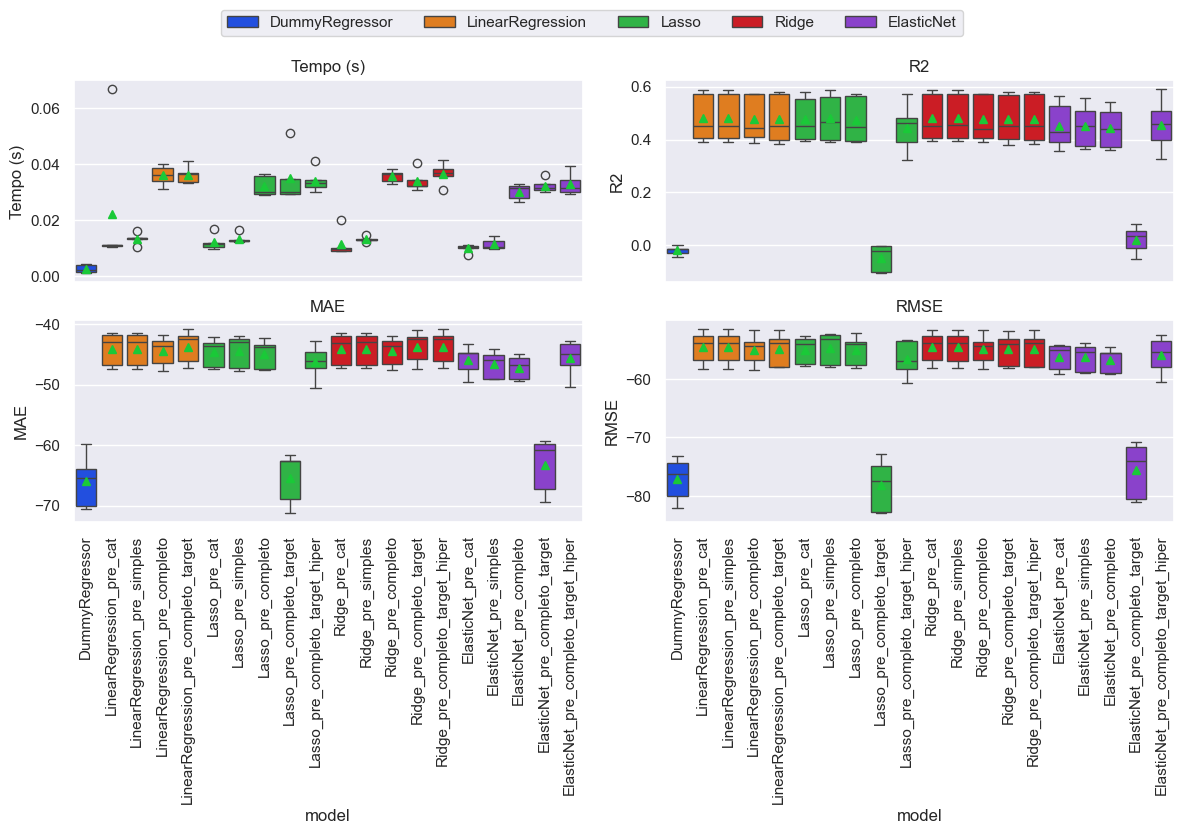

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

comparar_metricas = [
    "time_seconds",
    "test_r2",
    "test_neg_mean_absolute_error",
    "test_neg_root_mean_squared_error",
]

nomes_metricas = [
    "Tempo (s)",
    "R2",
    "MAE",
    "RMSE"
]

for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):
    sns.boxplot(
        x="model",
        y=metrica,
        data=df_resultados,
        ax=ax,
        showmeans=True,
        hue="model_group"
    )
    ax.set_title(nome)
    ax.set_ylabel(nome)
    ax.tick_params(axis="x", rotation=90)

    legend = ax.get_legend()
    labels = [text.get_text() for text in legend.get_texts()]
    ax.get_legend().remove()

fig.legend(
    handles=legend.legend_handles,
    labels=labels,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.5, 1.05),
)

plt.tight_layout()
plt.show()